# Import relevant libraries

In [1]:
#import libries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.pipeline import Pipeline

from sklearn import metrics 

In [2]:
#load dataset
df = pd.read_csv('./datasets/cleaned_v2.csv', low_memory = False)

In [3]:
# pd.set_option('display.max_columns', None)
df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,political_parties,remaining_lease_days,blk_num,blk_alpha,transaction_year,transaction_month,lease_year
0,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,9000.0,PAP,31411,309,-,1990,1,1977
1,ANG MO KIO,1 ROOM,04 TO 06,31.0,IMPROVED,6000.0,PAP,31411,309,-,1990,1,1977
2,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,8000.0,PAP,31411,309,-,1990,1,1977
3,ANG MO KIO,1 ROOM,07 TO 09,31.0,IMPROVED,6000.0,PAP,31411,309,-,1990,1,1977
4,ANG MO KIO,3 ROOM,04 TO 06,73.0,NEW GENERATION,47200.0,PAP,31046,216,-,1990,1,1976


# Preprocessing of Data

## Split data into features and target

In [4]:
X = df.drop(columns = 'resale_price')
y = df['resale_price']

In [5]:
X.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,political_parties,remaining_lease_days,blk_num,blk_alpha,transaction_year,transaction_month,lease_year
0,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,PAP,31411,309,-,1990,1,1977
1,ANG MO KIO,1 ROOM,04 TO 06,31.0,IMPROVED,PAP,31411,309,-,1990,1,1977
2,ANG MO KIO,1 ROOM,10 TO 12,31.0,IMPROVED,PAP,31411,309,-,1990,1,1977
3,ANG MO KIO,1 ROOM,07 TO 09,31.0,IMPROVED,PAP,31411,309,-,1990,1,1977
4,ANG MO KIO,3 ROOM,04 TO 06,73.0,NEW GENERATION,PAP,31046,216,-,1990,1,1976


In [6]:
y.head()

0     9000.0
1     6000.0
2     8000.0
3     6000.0
4    47200.0
Name: resale_price, dtype: float64

Remarks: X and y has been split

## Initiate train_test_split()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Show split of train and test data

In [8]:
print(len(X_train), len(X_test))

674251 224751


In [9]:
print(len(y_train),len(y_test) )

674251 224751


In [10]:
# reset index
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

Remarks: Train test split was sucessful 

### Split X_train & X_test into categorical and numerical.

#### X_train

In [11]:
columns = X_train.columns
columns

Index(['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'political_parties', 'remaining_lease_days', 'blk_num', 'blk_alpha',
       'transaction_year', 'transaction_month', 'lease_year'],
      dtype='object')

In [12]:
cat_X_train = pd.DataFrame()
num_X_train = pd.DataFrame()
for i in columns:
    if 'object' == str(X_train[i].dtypes):
        cat_X_train = pd.concat([cat_X_train, X_train[i]], axis = 1)
    else:
        num_X_train = pd.concat([num_X_train, X_train[i]], axis = 1)

In [13]:
cat_X_train.head()

,town,flat_type,storey_range,flat_model,political_parties,blk_alpha
0,CLEMENTI,3 ROOM,07 TO 09,NEW GENERATION,PAP,-
1,JURONG WEST,4 ROOM,04 TO 06,IMPROVED,PAP,-
2,HOUGANG,4 ROOM,01 TO 03,MODEL A,WP,-
3,ANG MO KIO,3 ROOM,07 TO 09,NEW GENERATION,PAP,-
4,TOA PAYOH,4 ROOM,16 TO 18,IMPROVED,PAP,-


In [14]:
num_X_train.head()

,floor_area_sqm,remaining_lease_days,blk_num,transaction_year,transaction_month,lease_year
0,67.0,25294,306,2008,10,1979
1,87.0,27820,219,1997,11,1975
2,103.0,26451,130,2010,8,1984
3,68.0,31380,332,1994,2,1981
4,82.0,23011,227,2012,1,1976


As the dates are in continuous format, it would be best to not perform one hot encoding.
Strategy: 
1. add date columns to X_train
2. drop date columns from cat_X_train

#### X_test

In [15]:
columns_test = X_test.columns
columns_test

Index(['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'political_parties', 'remaining_lease_days', 'blk_num', 'blk_alpha',
       'transaction_year', 'transaction_month', 'lease_year'],
      dtype='object')

In [16]:
cat_X_test = pd.DataFrame()
num_X_test = pd.DataFrame()
for i in columns:
    if 'object' == str(X_test[i].dtypes):
        cat_X_test = pd.concat([cat_X_test, X_test[i]], axis = 1)
    else:
        num_X_test = pd.concat([num_X_test, X_test[i]], axis = 1)

In [17]:
cat_X_test.head()

,town,flat_type,storey_range,flat_model,political_parties,blk_alpha
0,BUKIT BATOK,3 ROOM,07 TO 09,NEW GENERATION,PAP,-
1,JURONG EAST,3 ROOM,13 TO 15,IMPROVED,PAP,-
2,HOUGANG,4 ROOM,07 TO 09,SIMPLIFIED,WP,-
3,SENGKANG,3 ROOM,13 TO 15,MODEL A,PAP,C
4,KALLANG/WHAMPOA,4 ROOM,16 TO 18,MODEL A,PAP,-


In [18]:
num_X_test.head()

,floor_area_sqm,remaining_lease_days,blk_num,transaction_year,transaction_month,lease_year
0,68.0,31991,364,1998,6,1987
1,77.0,21884,33,2016,2,1977
2,84.0,28947,636,2006,10,1987
3,67.0,34089,443,2017,9,2012
4,90.0,34028,13,2009,11,2004


As the dates are in continuous format, it would be best to not perform one hot encoding.
Strategy: 
1. add date columns to X_train
2. drop date columns from cat_X_train

In [19]:
print(cat_X_test.shape)
print(num_X_test.shape)

(224751, 6)
(224751, 6)


Remarks: columns have been split into categorical and numerical dataframes

## OneHotEncoder for cat_X_train & cat_X_test

In [20]:
print(cat_X_train.shape , cat_X_test.shape)

(674251, 6) (224751, 6)


In [21]:
encoder = OneHotEncoder()

In [22]:
X_train_encoded = encoder.fit_transform(cat_X_train)
X_test_encoded = encoder.transform(cat_X_test)

Remarks: OneHotEncoder have been created.

## Combine num_X and cat_X into X

In [23]:
X_train_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_train_encoded)
X_test_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_test_encoded)

In [24]:
print(X_train_encoded_df.shape, X_test_encoded_df.shape)

(674251, 93) (224751, 93)


In [25]:
X_train = pd.concat([num_X_train, X_train_encoded_df], axis = 1)
X_test = pd.concat([num_X_test, X_test_encoded_df], axis = 1)

In [26]:
print(X_train.shape)
print(X_test.shape)

(674251, 99)
(224751, 99)


Remarks: Columns has been concat.

# Scaling of Train & Test data

In [27]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [28]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\johnk\mambaforge\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# Linear Regression Model

In [29]:
print(Z_train.shape)
print(y_train.shape)

(674251, 99)
(674251,)


In [30]:
print(Z_test.shape)
print(y_test.shape)

(224751, 99)
(224751,)


In [31]:
lr = LinearRegression()

In [32]:
lr.fit(Z_train, y_train)

LinearRegression()

In [33]:
lr.score(Z_train,y_train)

0.8367793427487782

In [34]:
lr.score(Z_test, y_test)

0.8368822121211058

In [35]:
cross_val_score(lr, Z_train, y_train, cv = 5).mean()

-6.057579281781869e+22

In [36]:
predictions = lr.predict(Z_test)

In [37]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

65976.83226271995

In [38]:
base_y_test = y_test.reset_index(drop=True)

In [39]:
pred_df = pd.DataFrame(base_y_test)

In [40]:
pred_df = pd.concat([pred_df, pd.DataFrame({'model_predictions': predictions})], axis = 1)

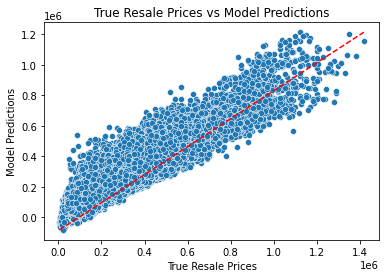

In [43]:
sns.scatterplot(x=pred_df['resale_price'], y=pred_df['model_predictions'])
plt.plot([min(pred_df['resale_price']), max(pred_df['resale_price'])], [min(pred_df['model_predictions']), max(pred_df['model_predictions'])], color='red', linestyle='--')
plt.title('True Resale Prices vs Model Predictions')
plt.xlabel('True Resale Prices')
plt.ylabel('Model Predictions')
plt.show()

The graph above provides insights into the model's performance in predicting housing prices. The presence of a linear trend suggests a general relationship between the predicted and true values.

Upon closer examination, it can be observed that the majority of the data points are consistently positioned above the diagonal line. This indicates the presence of a systematic bias in the model's predictions. The bias suggests that the model tends to consistently overestimate or underestimate the true values, leading to a consistent deviation from the ideal linear relationship.

Furthermore, the scatter of data points around the diagonal line suggests a certain degree of prediction error. The loosely scattered points indicate a relatively higher level of variability or uncertainty in the model's predictions. This suggests that the model may have limitations in accurately capturing the true housing prices, leading to a higher degree of prediction error.

In [ ]:
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

In [ ]:
ridgeCV_model = RidgeCV()
ridgeCV_model.fit(Z_train, y_train)

In [ ]:
ridgeCV_model.score(Z_train, y_train)

In [ ]:
ridgeCV_model.score(Z_test, y_test)

In [ ]:
predictions = ridgeCV_model.predict(Z_test)

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

In [ ]:
ridgeCV_coef = ridgeCV_model.coef_
ridgeCV_coef

Remarks: 

Train and test perfomance is better as compared to linear regression. As the test score and cross val scores are similar, it can be conclude that this model is representative for new future data. RMSE score is good too as there is a 4.5k +- range when predicting resale prices. 

Strategy: To explore another regularization technique such as Lasso CV to compare overall performance.

In [ ]:
lassoCV_model = LassoCV()
lassoCV_model.fit(Z_train, y_train)

In [ ]:
lassoCV_model.score(Z_train, y_train)

In [ ]:
lassoCV_model.score(Z_test, y_test)

In [ ]:
predictions = lassoCV_model.predict(Z_test)

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

In [ ]:
lassoCV_coef = lassoCV_model.coef_
lassoCV_coef

To plot `lassoCV_coef` into a dataframe with the feature names, you can follow these steps:

1. Get the feature names of your dataset. If you have a Pandas DataFrame, you can use the `columns` attribute to get the feature names. For example, if your dataset is named `data`, you can use `feature_names = data.columns.tolist()` to get the feature names as a list.

2. Create a DataFrame to store the coefficients and feature names. You can use the `pd.DataFrame()` function to create a new DataFrame, and pass in `lassoCV_coef` as the data argument.

3. Transpose the DataFrame. By default, the `pd.DataFrame()` function will create a DataFrame where each column represents a feature and each row represents a coefficient value. To make the feature names the row index and the coefficients the column values, you can use the `transpose()` method of the DataFrame. This will swap the rows and columns.

4. Rename the columns. The column names will be the integer indices of the features. To rename the columns with the feature names, you can use the `rename()` method of the DataFrame, and pass in a dictionary where the keys are the old column names (integer indices) and the values are the new column names (feature names). You can use a list comprehension to generate this dictionary.

Here's an example code snippet that demonstrates these steps:

``` python
import pandas as pd

# Get the feature names
feature_names = data.columns.tolist()

# Create a DataFrame with coefficients and feature names
coef_df = pd.DataFrame(lassoCV_coef, columns=feature_names)

# Transpose the DataFrame
coef_df = coef_df.transpose()

# Rename the columns with feature names
coef_df = coef_df.rename(columns={i: feature_names[i] for i in range(len(feature_names))})
```

After running this code, `coef_df` will be a Pandas DataFrame where each row represents a feature, each column represents a coefficient value, and the column names are the feature names.

Remarks:
Train and test perfomance is better as compared to linear regression. As the test score and cross val scores are similar, it can be conclude that this model is representative for new future data. The RMSE score is good too. However, it is not as good as RidgeCV. This difference in score could be due to LassoCV driving the coefficents to 0. Hence, this could have attributed to a slightly weaker performance as compared to RidgeCV. 

Strategy: To explore another regularization technique such as ElasticNet to compare overall performance.

In [ ]:
enet_alphas = np.linspace(0.5, 1.0, 100)
enet_model = ElasticNetCV(alphas = enet_alphas, cv = 5)

In [ ]:
enet_model.fit(Z_train, y_train)

In [ ]:
enet_model.score(Z_train, y_train)

In [ ]:
enet_model.score(Z_test, y_test)

In [ ]:
predictions = enet_model.predict(Z_test)

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

Remarks: 

Train and test perfomance is better as compared to linear regression. As the test score and cross val scores are similar, it can be conclude that this model is representative for new future data. However, it is not as great as compared to the other regularization models such as Ridgecv and LassoCV. 

In [ ]:
sc = StandardScaler()

In [ ]:
xgb = XGBRegressor()

In [ ]:
pipe_xgb_gs = Pipeline([('sc',sc),('xgb',xgb)])

In [ ]:
pipe_xgb_gs_params = {'xgb__max_depth':[7,8],
                      'xgb__eta':[0.2,0.3],
                      'xgb__random_state':[42]}

In [ ]:
xgb_gs = GridSearchCV(pipe_xgb_gs, pipe_xgb_gs_params, cv=5, verbose=1, error_score='raise')

In [ ]:
xgb_model = xgb_gs.fit(X_train, y_train);

In [ ]:
xgb_gs.best_params_

In [ ]:
xgb_gs.score(X_test,y_test)

In [ ]:
xgb_gs.score(X_train,y_train)

In [ ]:
predictions = xgb_model.predict(X_test)

In [ ]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

In [ ]:
predictions.shape

In [ ]:
y_test = y_test.reset_index(drop=True)

In [ ]:
pred_df = pd.DataFrame(y_test)

In [ ]:
pred_df.head()

In [ ]:
pred_df.shape

In [ ]:
pred_df = pd.concat([pred_df, pd.DataFrame({'model_predictions': predictions})], axis = 1)

In [ ]:
pred_df.shape

In [ ]:
pred_df.head()

In [ ]:
sns.scatterplot(x=pred_df['resale_price'], y=pred_df['model_predictions'])

Summary Table:


| Type of $R^2$ | Linear Regression | RidgeCV | LassoCV | Elastic Net |
| :------------: | :------------: | :------------: | :------------: | :------------: |
| Train|0.902|0.902|0.901|0.879|
| Test|0.901|0.901|0.901|0.879|
| Cross val |-5.703e+22|-|-|-|
| RMSE |45067.93|45059.24|45185.42|49799.30|

# Discussion

After fitting a linear regression model on the dataset, obtaining a train score and test score of 83.6% suggests that the model performs reasonably well on both the training and test data. The matching scores indicate that there is no apparent sign of overfitting or underfitting, which is generally desirable and the RMSE score is 65,976.

However, the cross-validation score of -6.05e+22 indicates a significant issue. This negative score strongly suggests the presence of model overfitting. Overfitting occurs when the model becomes too complex and starts capturing noise or irrelevant patterns from the training data. Consequently, it performs poorly on unseen data during cross-validation, resulting in a negative mean score.

The negative cross-validation score highlights the bad generalization of the model. It implies that the model's ability to accurately predict new, unseen data is severely compromised due to its overfitting behavior.

In addition, with the graph of true resale prices vs predicted prices, it is evident that the model can be improved predictive accuracy and reduce systematic bias in the model's predictions.

Given these findings, it is necessary to explore alternative models or techniques to improve both the train and test scores while addressing the issue of overfitting. This may involve adjusting model hyperparameters and trying different algorithms altogether. The goal is to enhance the model's generalization ability, ensuring that it can make accurate predictions on new data beyond the training set.